# Applying ML Model

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [41]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV,  KFold
from sklearn.metrics import confusion_matrix, classification_report, plot_confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve, auc, roc_auc_score, precision_recall_curve

In [14]:
from numpy import sqrt
from numpy import argmax
from matplotlib import pyplot

In [4]:
train_data = pd.read_csv("../main_dataset/train_processed_data.csv")
train_data.shape

(874, 9)

In [5]:
x = train_data.drop(['Survived','PassengerId'],axis =1).values
y = train_data['Survived'].values
x_train, x_test, y_train, y_test = train_test_split(x,y,test_size =0.2, random_state=303)

In [11]:
from sklearn import metrics
def model_compare(model_name,model,y_test,y_pred,y_score, roc_auc = None):
    binclass_metrics = {
                        'Accuracy' : metrics.accuracy_score(y_test, y_pred),
                        'Precision' : metrics.precision_score(y_test, y_pred),
                        'Recall' : metrics.recall_score(y_test, y_pred),
                        'F1 Score' : metrics.f1_score(y_test, y_pred),
                        'ROC AUC' : roc_auc
                       }

    df_metrics = pd.DataFrame.from_dict(binclass_metrics, orient='index')
    df_metrics.columns = [model_name] 
    return df_metrics

In [24]:
def selecting_optimal_thresholds(model,x_test,y_test):
    model_probs = model.predict_proba(x_test)
    model_probs = model_probs[:, 1]
    model_auc   = roc_auc_score(y_test, model_probs)

    fpr, tpr, thresholds = roc_curve(y_test, model_probs)

    gmeans = sqrt(tpr * (1-fpr))
    
    ix = argmax(gmeans)
    # ix = 25
    print('Best Threshold=%f, G-Mean=%.3f' % (thresholds[ix], gmeans[ix]))

    # plot the roc curve for the model
    pyplot.plot([0,1], [0,1], linestyle='--', label='No Skill')
    pyplot.plot(fpr, tpr, marker='.', label='Logistic')
    pyplot.scatter(fpr[ix], tpr[ix], marker='o', color='black', label='Best')
    # axis labels
    pyplot.xlabel('False Positive Rate')
    pyplot.ylabel('True Positive Rate')
    pyplot.legend()
    # show the plot
    pyplot.show()
    
    precision, recall, thresholds = precision_recall_curve(y_test, model_probs)
    # convert to f score
    fscore = (2 * precision * recall) / (precision + recall)
    # locate the index of the largest f score
    ix = argmax(fscore)
    print('Best Threshold=%f, F-Score=%.3f' % (thresholds[ix], fscore[ix]))
    
    # plot the roc curve for the model
    no_skill = len(y_test[y_test==1]) / len(y_test)
    pyplot.plot([0,1], [no_skill,no_skill], linestyle='--', label='No Skill')
    pyplot.plot(recall, precision, marker='.', label='Logistic')
    pyplot.scatter(recall[ix], precision[ix], marker='o', color='black', label='Best')
    # axis labels
    pyplot.xlabel('Recall')
    pyplot.ylabel('Precision')
    pyplot.legend()
    # show the plot
    pyplot.show()

In [126]:
def draw_confusion_matrix_binary(y_test,y_pred,model=None):
    matrixdata = confusion_matrix(y_test, y_pred, labels=[1,0])
    group_names  = ['TP','FN','FP','TN'] # ['TN','FP','FN','TP']
    group_counts = ["{0:0.0f}".format(value) for value in
                matrixdata.flatten()]
    categories = ['Zero', 'One']
    labels = [f"{v1}\n{v2}" for v1, v2 in
          zip(group_names,group_counts)]
    labels = np.asarray(labels).reshape(2,2)
    sns.heatmap(matrixdata, annot=labels, cmap='Blues' , fmt='') # cmap='Blues' , fmt=''   categories=categories,cmap='binary'
    
    plt.xlabel('Predicted Values')
    plt.ylabel('Actual Values')
    plt.title('Actual vs. Predicted Confusion Matrix')
    plt.show()
    
    print(f" TPR  => {matrixdata[0][0]/(matrixdata[0][0] + matrixdata[0][1])} \n")
    print(f" FPR  => {(1 - (matrixdata[1][1]/(matrixdata[1][0] + matrixdata[1][1])))} \n")
    print(classification_report(y_test, y_pred, labels=[1,0]))

## DecisionTree

In [57]:
from sklearn.tree import DecisionTreeClassifier

In [6]:
model_dt = DecisionTreeClassifier(random_state=303)
np.random.seed(303)
# start = time.time()
param_dist = {'max_depth': [2, 3, 4, 5, 6, 7],
              'min_samples_leaf':[100,200,70, 30],
              'criterion': ['gini', 'entropy']}

cv_rf = GridSearchCV(model_dt, cv = 10,
                     param_grid=param_dist, 
                     n_jobs = 1)

cv_rf.fit(x_train, y_train)
print('Best Parameters using grid search: \n', cv_rf.best_params_)

Best Parameters using grid search: 
 {'criterion': 'gini', 'max_depth': 4, 'min_samples_leaf': 30}


In [58]:
model_dt = DecisionTreeClassifier(random_state=303,
                                  max_depth=4, 
                                  criterion = 'gini', 
                                  min_samples_leaf=30 )
model_dt.fit(x_train, y_train)
model_dt_score_train = model_dt.score(x_train, y_train)
print("Training score: ",model_dt_score_train)
model_dt_score_test = model_dt.score(x_test, y_test)
print("Testing score: ",model_dt_score_test)

Training score:  0.8140200286123033
Testing score:  0.7885714285714286


In [59]:
y_pred = model_dt.predict(x_test)
# Model Accuracy
print (model_dt.score(x_test, y_test))

0.7885714285714286


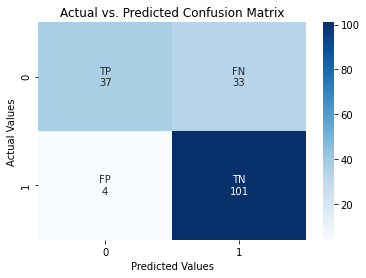

 TPR  => 0.5285714285714286 

 FPR  => 0.03809523809523807 

              precision    recall  f1-score   support

           1       0.90      0.53      0.67        70
           0       0.75      0.96      0.85       105

    accuracy                           0.79       175
   macro avg       0.83      0.75      0.76       175
weighted avg       0.81      0.79      0.77       175



,Decision Tree
Accuracy,0.788571
Precision,0.902439
Recall,0.528571
F1 Score,0.666667
ROC AUC,0.745238


In [127]:
y_pred = model_dt.predict(x_test)
fpr_dt, tpr_dt, _ = roc_curve(y_test, y_pred)
roc_auc = auc(fpr_dt, tpr_dt)
y_score = accuracy_score(y_test, y_pred)
draw_confusion_matrix_binary(y_test,y_pred)
metrix_dt = model_compare("Decision Tree",model_dt, y_test, y_pred, y_score, roc_auc  )
metrix_dt

### SELECTING OPTIMAL Thresholds  

Best Threshold=0.451613, G-Mean=0.828


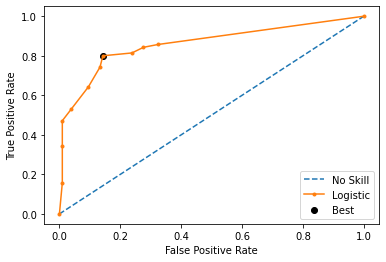

Best Threshold=0.451613, F-Score=0.794


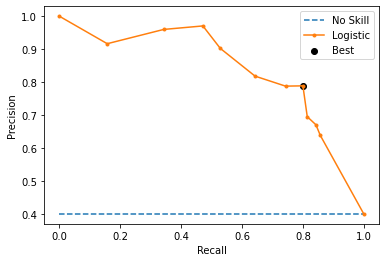

In [128]:
selecting_optimal_thresholds(model_dt,x_test,y_test)

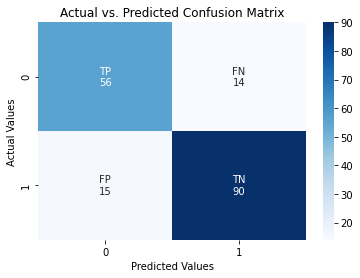

 TPR  => 0.8 

 FPR  => 0.1428571428571429 

              precision    recall  f1-score   support

           1       0.79      0.80      0.79        70
           0       0.87      0.86      0.86       105

    accuracy                           0.83       175
   macro avg       0.83      0.83      0.83       175
weighted avg       0.83      0.83      0.83       175



,Decision Tree ROC
Accuracy,0.834286
Precision,0.788732
Recall,0.800000
F1 Score,0.794326
ROC AUC,0.828571


In [129]:
y_pred = (model_dt.predict_proba(x_test)[:,1] >= 0.4516).astype(bool) 
fpr_dt, tpr_dt, _ = roc_curve(y_test, y_pred)
roc_auc = auc(fpr_dt, tpr_dt)
y_score = accuracy_score(y_test, y_pred)
draw_confusion_matrix_binary(y_test,y_pred)
roc_metrix_dt = model_compare("Decision Tree ROC ",model_dt, y_test, y_pred, y_score, roc_auc  )
roc_metrix_dt

In [27]:
metrix_dt

,Decision Tree
Accuracy,0.788571
Precision,0.902439
Recall,0.528571
F1 Score,0.666667
ROC AUC,0.745238


## Random Forest

In [27]:
from sklearn.ensemble import RandomForestClassifier

In [28]:
model_rf = RandomForestClassifier(random_state=303)

In [12]:
param_dist = {'max_depth': [3,4,5,7,8],
              'bootstrap': [True, False],
              'max_features': ['auto', 'sqrt', 'log2', None],
              'criterion': ['gini', 'entropy']}

cv_rf = GridSearchCV(model_rf, cv = 10,
                     param_grid=param_dist, 
                     n_jobs = 1)

cv_rf.fit(x_train, y_train)
print('Best Parameters using grid search: \n', cv_rf.best_params_)

Best Parameters using grid search: 
 {'bootstrap': True, 'criterion': 'gini', 'max_depth': 8, 'max_features': 'auto'}


In [29]:
model_rf.set_params(criterion    = 'gini',
                    max_features = 'auto', 
                    max_depth    = 8,
                    bootstrap    = True
                   )

RandomForestClassifier(max_depth=8, random_state=303)

In [107]:
model_rf.set_params(warm_start=True, 
                  oob_score=True)

min_estimators = 1000
max_estimators = 1500

error_rate = {}

for i in range(min_estimators, max_estimators + 1):
    model_rf.set_params(n_estimators=i)
    model_rf.fit(x_train, y_train)

    oob_error = 1 - model_rf.oob_score_
    error_rate[i] = oob_error

oob_series = pd.Series(error_rate)

c:\users\melwin\.conda\envs\tutorialdatascience\lib\site-packages\sklearn\ensemble\_forest.py:368: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  warn("Warm-start fitting without increasing n_estimators does not "


Text(0.5, 1.0, 'OOB Error Rate Across various Forest sizes \n(From 15 to 1000 trees)')

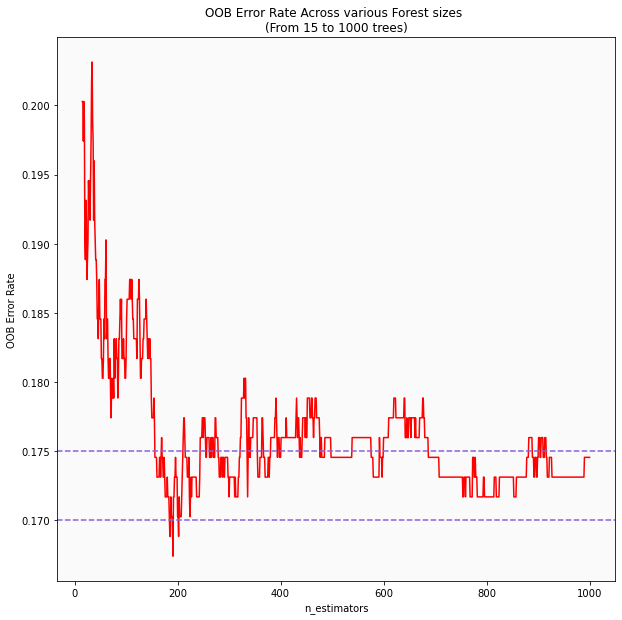

In [106]:
fig, ax = plt.subplots(figsize=(10, 10))

ax.set_facecolor('#fafafa')

oob_series.plot(kind='line',color = 'red')
plt.axhline(0.175, color='#875FDB',linestyle='--')
plt.axhline(0.170, color='#875FDB',linestyle='--')
plt.xlabel('n_estimators')
plt.ylabel('OOB Error Rate')
plt.title('OOB Error Rate Across various Forest sizes \n(From 15 to 1000 trees)')

Text(0.5, 1.0, 'OOB Error Rate Across various Forest sizes \n(From 1000 to 1500 trees)')

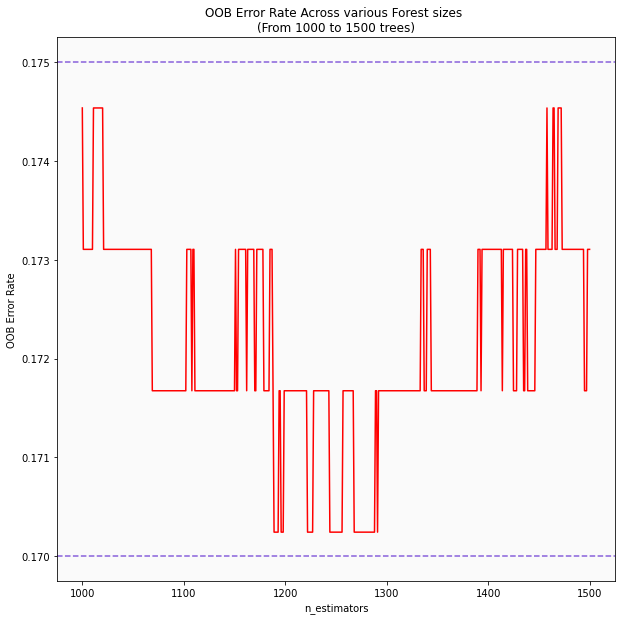

In [109]:
fig, ax = plt.subplots(figsize=(10, 10))

ax.set_facecolor('#fafafa')

oob_series.plot(kind='line',color = 'red')
plt.axhline(0.175, color='#875FDB',linestyle='--')
plt.axhline(0.170, color='#875FDB',linestyle='--')
plt.xlabel('n_estimators')
plt.ylabel('OOB Error Rate')
plt.title('OOB Error Rate Across various Forest sizes \n(From 1000 to 1500 trees)')

In [30]:
model_rf.set_params(n_estimators=750,
                  bootstrap = True,
                  warm_start=False, 
                  oob_score=False)

RandomForestClassifier(max_depth=8, n_estimators=750, random_state=303)

In [38]:
model_rf.fit(x_train, y_train)
y_score= metrics.accuracy_score(y_test, prediction_test)
y_pred= model_rf.predict(x_test)
#########################################################
fpr_dt, tpr_dt, _ = roc_curve(y_test, y_pred)
roc_auc_rf = auc(fpr_dt, tpr_dt)
#########################################################

metrix_rf = model_compare("Random Forest",model_rf, y_test, prediction_test, y_score , roc_auc_rf )
metrix_rf

[[48 22]
 [ 6 99]]
 TPR => 0.8888888888888888
 FPR => 0.18181818181818182
              precision    recall  f1-score   support

           1       0.89      0.69      0.77        70
           0       0.82      0.94      0.88       105

    accuracy                           0.84       175
   macro avg       0.85      0.81      0.83       175
weighted avg       0.85      0.84      0.84       175



,Random Forest
Accuracy,0.840000
Precision,0.888889
Recall,0.685714
F1 Score,0.774194
ROC AUC,0.814286


### SELECTING OPTIMAL Thresholds

Best Threshold=0.408479, G-Mean=0.814


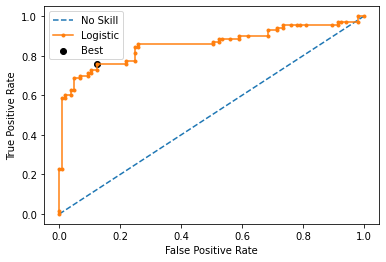

Best Threshold=0.522483, F-Score=0.780


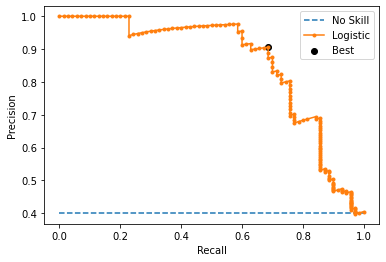

In [34]:
selecting_optimal_thresholds(model_rf,x_test,y_test )

In [36]:
y_pred = (model_rf.predict_proba(x_test)[:,1] >= 0.408479).astype(bool) 
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_pred)
roc_auc = auc(fpr_rf, tpr_rf)
y_score = accuracy_score(y_test, y_pred)
matrixdata = confusion_matrix(y_test, y_pred, labels=[1,0])
print(matrixdata)
print(f" TPR => {matrixdata[0][0]/(matrixdata[0][0] + matrixdata[1][0])}")
print(f" FPR => {matrixdata[0][1]/(matrixdata[0][1] + matrixdata[1][1])}")
print(classification_report(y_test, y_pred, labels=[1,0]))
roc_metrix_rf = model_compare("Random Forest ROC ",model_rf, y_test, y_pred, y_score, roc_auc  )
roc_metrix_rf

[[53 17]
 [13 92]]
 TPR => 0.803030303030303
 FPR => 0.1559633027522936
              precision    recall  f1-score   support

           1       0.80      0.76      0.78        70
           0       0.84      0.88      0.86       105

    accuracy                           0.83       175
   macro avg       0.82      0.82      0.82       175
weighted avg       0.83      0.83      0.83       175



,Random Forest ROC
Accuracy,0.828571
Precision,0.803030
Recall,0.757143
F1 Score,0.779412
ROC AUC,0.816667


In [84]:
metrix_rf

,Random Forest
Accuracy,0.840000
Precision,0.888889
Recall,0.685714
F1 Score,0.774194
ROC AUC,0.856190


## Naive Bayes

In [74]:
from sklearn.naive_bayes import MultinomialNB

In [81]:
model_nb = MultinomialNB().fit(x_train, y_train)
prediction_test = model_nb.predict(x_test)
y_score= metrics.accuracy_score(y_test, prediction_test)
y_pred= model_nb.predict(x_test)
fpr_dt, tpr_dt, _ = roc_curve(y_test, y_pred)
roc_auc_rf = auc(fpr_dt, tpr_dt)
metrix_nb = model_compare("Naive Bayes",model_nb, y_test, prediction_test, y_score , roc_auc_rf )
metrix_nb

,Naive Bayes
Accuracy,0.697143
Precision,0.673469
Recall,0.471429
F1 Score,0.554622
ROC AUC,0.659524


Best Threshold=0.005808, G-Mean=0.740


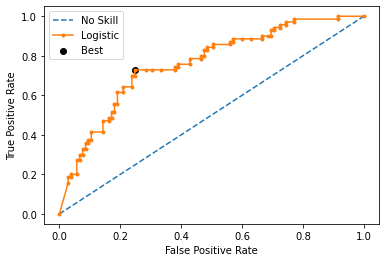

Best Threshold=0.005808, F-Score=0.694


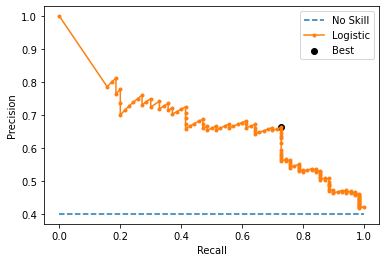

In [97]:
selecting_optimal_thresholds(model_nb,x_test,y_test )

In [80]:
y_pred = (model_nb.predict_proba(x_test)[:,1] >= 0.005808).astype(bool) 
fpr_nb, tpr_nb, _ = roc_curve(y_test, y_pred)
roc_auc = auc(fpr_nb, tpr_nb)
y_score = accuracy_score(y_test, y_pred)
roc_metrix_nb = model_compare("Naive Bayes ROC ",model_nb, y_test, y_pred, y_score, roc_auc  )
roc_metrix_nb

,Naive Bayes ROC
Accuracy,0.742857
Precision,0.662338
Recall,0.728571
F1 Score,0.693878
ROC AUC,0.740476


In [82]:
metrix_nb

,Naive Bayes
Accuracy,0.697143
Precision,0.673469
Recall,0.471429
F1 Score,0.554622
ROC AUC,0.659524


## SVM

In [85]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(x)
x1 = scaler.transform(x)

In [86]:
x1_train, x1_test, y1_train, y1_test = train_test_split(x1,y,test_size =0.2, random_state=303)

In [87]:
from sklearn.svm import SVC

In [127]:
tuned_parameters = {
 'C': (np.arange(0.1,1,0.1)) , 'kernel': ['linear'],
 'C': (np.arange(0.1,1,0.1)) , 'gamma': [0.01,0.02,0.03,0.04,0.05], 'kernel': ['rbf'],
 'degree': [2,3,4] ,'gamma':[0.01,0.02,0.03,0.04,0.05], 'C':(np.arange(0.1,1,0.1)) , 'kernel':['poly']
                   }
model_svc= SVC()
model_svm = GridSearchCV(model_svc, tuned_parameters,cv=10,scoring='accuracy')
model_svm.fit(x_train, y_train)
print(model_svm.best_score_)
print(model_svm.best_params_)

0.7153209109730848
{'C': 0.9, 'degree': 2, 'gamma': 0.05, 'kernel': 'poly'}


In [88]:
model_svc = SVC(kernel='poly',gamma=0.05, degree=3, C=0.9 )
model_svc.fit(x1_train,y1_train)
y_pred=model_svc.predict(x1_test)
print('Accuracy Score:')
print(metrics.accuracy_score(y1_test,y_pred))
y_pred = model_svc.predict(x1_test)
y_score = metrics.accuracy_score(y1_test, y_pred)
#########################################################
# y_pred = model_svm.predict_proba(x_test)
fpr_svc, tpr_svc, _ = roc_curve(y_test, y_pred)
roc_auc_svm = auc(fpr_svc, tpr_svc)
#########################################################
metrix_svm = model_compare("SVM poly", model_svc, y_test, y_pred, y_score, roc_auc_svm )
metrix_svm

Accuracy Score:
0.7028571428571428


,SVM poly
Accuracy,0.702857
Precision,0.950000
Recall,0.271429
F1 Score,0.422222
ROC AUC,0.630952


### GradientBoosting

In [127]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import make_scorer

In [130]:
model_GB = GradientBoostingClassifier(
                                        learning_rate = 0.01,
                                        max_depth = 8,
                                        max_features = 'auto',
                                        min_samples_leaf = 30,
                                        min_samples_split = 40,
                                        n_estimators = 750
                                     )
model_GB.fit(x_train, y_train)
y_pred=model_GB.predict(x_test)
y_score = metrics.accuracy_score(y_test, y_pred)
fpr_dt, tpr_dt, _ = roc_curve(y_test, y_pred)
roc_auc_GB = auc(fpr_dt, tpr_dt)
metrix_GB = model_compare("GB", model_GB, y_test, y_pred, y_score, roc_auc_GB )
metrix_GB

,GB
Accuracy,0.874286
Precision,0.913793
Recall,0.757143
F1 Score,0.828125
ROC AUC,0.854762


Best Threshold=0.515719, G-Mean=0.849


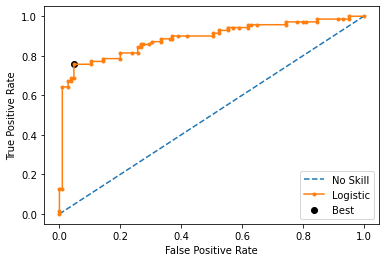

Best Threshold=0.515719, F-Score=0.828


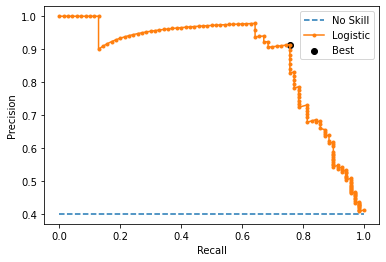

In [131]:
selecting_optimal_thresholds(model_GB,x_test,y_test )

In [132]:
y_pred = (model_GB.predict_proba(x_test)[:,1] >= 0.515719).astype(bool) 
fpr_gb, tpr_gb, _ = roc_curve(y_test, y_pred)
roc_auc = auc(fpr_gb, tpr_gb)
y_score = accuracy_score(y_test, y_pred)
roc_metrix_gb = model_compare("GB ROC ",model_GB, y_test, y_pred, y_score, roc_auc  )
roc_metrix_gb

,GB ROC
Accuracy,0.868571
Precision,0.912281
Recall,0.742857
F1 Score,0.818898
ROC AUC,0.847619


In [133]:
metrix_GB

,GB
Accuracy,0.874286
Precision,0.913793
Recall,0.757143
F1 Score,0.828125
ROC AUC,0.854762


In [145]:
metrics_bn_new = pd.concat([metrix_dt, roc_metrix_dt, metrix_rf, roc_metrix_rf, metrix_nb, roc_metrix_nb, metrix_svm, metrix_GB, roc_metrix_gb], axis=1)
metrics_bn_new

,Decision Tree,Decision Tree ROC,Random Forest,Random Forest ROC,Naive Bayes,Naive Bayes ROC,SVM poly,GB,GB ROC
Accuracy,0.788571,0.834286,0.840000,0.828571,0.697143,0.742857,0.702857,0.874286,0.868571
Precision,0.902439,0.788732,0.888889,0.803030,0.673469,0.662338,0.950000,0.913793,0.912281
Recall,0.528571,0.800000,0.685714,0.757143,0.471429,0.728571,0.271429,0.757143,0.742857
F1 Score,0.666667,0.794326,0.774194,0.779412,0.554622,0.693878,0.422222,0.828125,0.818898
ROC AUC,0.745238,0.828571,0.856190,0.816667,0.659524,0.740476,0.630952,0.854762,0.847619


# ROC AUC CURVE OF ALL THE MODEL

### No we will focus on selecting the best threshold for maximum accuracy

In [29]:
pred=[]
for model in [model_dt,model_rf,model_nb]:
    pred.append(pd.Series(model.predict_proba(x_test)[:,1]))
final_prediction=pd.concat(pred,axis=1).mean(axis=1)
print('Ensemble test roc-auc: {}'.format(roc_auc_score(y_test,final_prediction)))

Ensemble test roc-auc: 0.8446258503401359


In [30]:
pd.concat(pred,axis=1)

,0,1,2
0,0.310345,0.424925,0.964379
1,0.093426,0.110220,0.000191
2,0.880000,0.832976,0.133450
3,0.468085,0.585095,0.006187
4,0.310345,0.442615,0.000319
...,...,...,...
170,0.483871,0.541355,0.801780
171,0.093426,0.114579,0.020222
172,0.451613,0.368103,0.982509
173,0.093426,0.256441,0.999987


In [31]:

#### Calculate the ROc Curve


fpr, tpr, thresholds = roc_curve(y_test, final_prediction)
thresholds

array([1.98719708, 0.98719708, 0.76195709, 0.71992834, 0.67854961,
       0.64140693, 0.6320097 , 0.62728734, 0.62606027, 0.62393349,
       0.60574142, 0.60074185, 0.58511218, 0.57822964, 0.57197172,
       0.55776434, 0.53529669, 0.52399923, 0.47694218, 0.46526847,
       0.46201582, 0.44995117, 0.41244905, 0.40227828, 0.35820939,
       0.33868413, 0.32039158, 0.30193232, 0.27300325, 0.26916205,
       0.25109314, 0.23867839, 0.10629791, 0.09952784, 0.09780271,
       0.09539992, 0.07800106, 0.07782643, 0.07749512, 0.07713508,
       0.07665203, 0.07607535, 0.07490717, 0.07393174, 0.07088995,
       0.06950178, 0.06758059, 0.06511083, 0.06450563, 0.06328352,
       0.0629039 , 0.0614913 , 0.06103767, 0.05649866, 0.05567849,
       0.05304359, 0.05204418, 0.05198931, 0.05059463, 0.04736258,
       0.04581128])

In [32]:
from sklearn.metrics import accuracy_score
accuracy_ls = []
for thres in thresholds:
    y_pred = np.where(final_prediction>thres,1,0)
    accuracy_ls.append(accuracy_score(y_test, y_pred, normalize=True))
    
accuracy_ls = pd.concat([pd.Series(thresholds), pd.Series(accuracy_ls)],
                        axis=1)
accuracy_ls.columns = ['thresholds', 'accuracy']
accuracy_ls.sort_values(by='accuracy', ascending=False, inplace=True)
accuracy_ls.head()

,thresholds,accuracy
27,0.301932,0.794286
22,0.412449,0.794286
21,0.449951,0.794286
19,0.465268,0.794286
18,0.476942,0.788571


In [45]:
# Random FOREST AFTER settting best threshold

In [46]:
prediction_test = (model_rf.predict_proba(x_test)[:,1] >= 0.476).astype(bool) 
y_score= metrics.accuracy_score(y_test, prediction_test)
y_pred= model_rf.predict(x_test)
#########################################################
y_pred = model_rf.predict_proba(x_test)[:, 1]
fpr_dt, tpr_dt, _ = roc_curve(y_test, y_pred)
roc_auc_rf = auc(fpr_dt, tpr_dt)
#########################################################
roc_metrix_rf = model_compare("Random Forest ROC",model_rf, y_test, prediction_test, y_score , roc_auc_rf )
roc_metrix_rf

,Random Forest ROC
Accuracy,0.840000
Precision,0.888889
Recall,0.685714
F1 Score,0.774194
ROC AUC,0.856190


In [48]:
y_pred = (model_dt.predict_proba(x_test)[:,1] >= 0.465).astype(bool) 
fpr_dt, tpr_dt, _ = roc_curve(y_test, y_pred)
roc_auc = auc(fpr_dt, tpr_dt)
y_score = accuracy_score(y_test, y_pred)
roc_metrix_dt = model_compare("Decision Tree ROC ",model_dt, y_test, y_pred, y_score, roc_auc  )
roc_metrix_dt

,Decision Tree ROC
Accuracy,0.817143
Precision,0.787879
Recall,0.742857
F1 Score,0.764706
ROC AUC,0.804762


In [51]:
prediction_test = (model_nb.predict_proba(x_test)[:,1] >= 0.44).astype(bool) 
y_score= metrics.accuracy_score(y_test, prediction_test)
y_pred= model_nb.predict(x_test)
y_pred = model_nb.predict_proba(x_test)[:, 1]
fpr_dt, tpr_dt, _ = roc_curve(y_test, y_pred)
roc_auc_rf = auc(fpr_dt, tpr_dt)
roc_metrix_nb = model_compare("Naive Bayes ROC",model_nb, y_test, prediction_test, y_score , roc_auc_rf )
roc_metrix_nb

,Naive Bayes ROC
Accuracy,0.697143
Precision,0.673469
Recall,0.471429
F1 Score,0.554622
ROC AUC,0.760884


In [55]:
metrics_bn_roc_new = pd.concat([roc_metrix_dt, roc_metrix_rf, roc_metrix_nb], axis=1)
metrics_bn_roc_new

,Decision Tree ROC,Random Forest ROC,Naive Bayes ROC
Accuracy,0.817143,0.840000,0.697143
Precision,0.787879,0.888889,0.673469
Recall,0.742857,0.685714,0.471429
F1 Score,0.764706,0.774194,0.554622
ROC AUC,0.804762,0.856190,0.760884


In [38]:
metrics_bn_new

,Decision Tree,Random Forest,Naive Bayes,SVM poly
Accuracy,0.788571,0.840000,0.697143,0.702857
Precision,0.902439,0.888889,0.673469,0.950000
Recall,0.528571,0.685714,0.471429,0.271429
F1 Score,0.666667,0.774194,0.554622,0.422222
ROC AUC,0.745238,0.856190,0.760884,0.630952


In [70]:
## By Looking at this all this model Random Forest is Giving you the Best Out 
## with respect to the ROC AUC CURVE , Recall, ..etc

In [134]:
final_model = GradientBoostingClassifier(
                                        learning_rate = 0.01,
                                        max_depth = 8,
                                        max_features = 'auto',
                                        min_samples_leaf = 30,
                                        min_samples_split = 40,
                                        n_estimators = 750
                                     )

In [135]:
x = train_data.drop(['Survived','PassengerId'],axis =1).values
y = train_data['Survived'].values

In [136]:
final_model.fit(x, y)

GradientBoostingClassifier(learning_rate=0.01, max_depth=8, max_features='auto',
                           min_samples_leaf=30, min_samples_split=40,
                           n_estimators=750)

In [137]:
test_data = pd.read_csv("../main_dataset/test_processed_data.csv")

In [138]:
x_test = test_data.drop(['PassengerId'],axis =1).values

In [139]:
# prediction_test = (final_model.predict_proba(x_test)[:,1] >= 0.4516).astype(int)
prediction_test  = final_model.predict(x_test)

In [140]:
prediction_test

array([0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1,
       1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1,
       1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1,
       1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1,
       1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1,
       0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1,
       1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1,
       0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0,
       1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,
       0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,

In [141]:
test_data.insert(1,column="Survived",value=prediction_test)

In [142]:
test_data.drop([feature for feature in test_data.columns if feature not in ['PassengerId','Survived'] ],axis=1,inplace= True)

In [143]:
test_data.to_csv('../main_dataset/Test_predictions.csv',index=False)

In [144]:
test_data.head()

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,1
